In [1]:
from UDR.udr import train_test_ppo_with_udr

n_episodes = 800
mean_timestep = 300
optimized_clip_range_source = 0.219204216258128
target_env = "CustomHopper-target-v0"
source_env = "CustomHopper-source-v0"
base_output_folder = "./udr_output"


deltas = [0.2, 0.4, 0.6, 0.8]
for delta in deltas:
	output_folder = f"{base_output_folder}/{delta}"

	train_test_ppo_with_udr(
		output_folder=output_folder,
		train_env=source_env,
		test_env=target_env,
		episodes=n_episodes,
		clip_range=optimized_clip_range_source,
		timesteps=mean_timestep,
		delta=delta
	)

/opt/miniconda3/envs/mldl_m4/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean episode length
160.2601194426012
mean train reward
455.6798767472538
mean test reward
586.4286340921175
test rewards file: ./udr_output/0.2/test_rewards_CustomHopper-target-v0.txt
mean episode length
145.5717732207479
mean train reward
409.02066035674216
mean test reward
460.52514472362304
test rewards file: ./udr_output/0.4/test_rewards_CustomHopper-target-v0.txt
mean episode length
151.19399249061325
mean train reward
413.779812287601
mean test reward
562.8246257538774
test rewards file: ./udr_output/0.6/test_rewards_CustomHopper-target-v0.txt
mean episode length
154.10791826309068
mean train reward
428.5811557310685
mean test reward
437.1586018899774
test rewards file: ./udr_output/0.8/test_rewards_CustomHopper-target-v0.txt


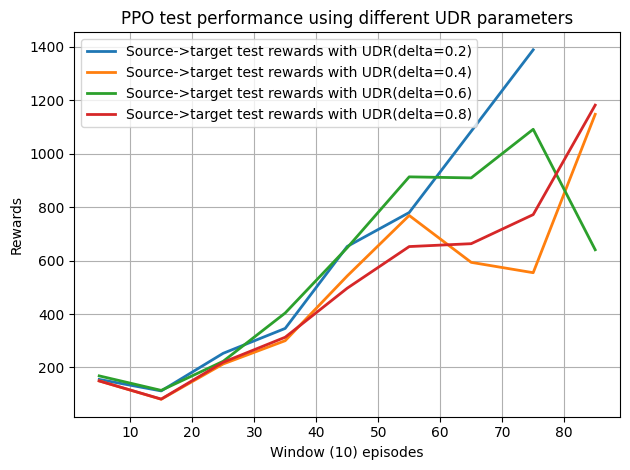

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def get_rewards (filename, window_size: int = 10):
    with open(filename, 'r') as f:
        lines = f.readlines()
        data = [float(line.strip()) for line in lines]

        means = []
        positions = []
        for i in range(0, len(data), window_size):
            window = data[i:i+window_size]
            mean_value = np.mean(window)
            means.append(mean_value)
            positions.append(i + window_size//2)
        
        return means, positions
    
path_test_resources = './udr_output'

for delta in deltas:
    r, p = get_rewards(f"{path_test_resources}/{delta}/test_rewards_CustomHopper-target-v0.txt")
    plt.plot(p, r, label=f'Source->target test rewards with UDR(delta={delta})', linewidth=2)

plt.ylabel("Rewards")
plt.xlabel(f"Window ({10}) episodes")
plt.title("PPO test performance using different UDR parameters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()